# Features Classification

In [1]:
# Requirements
import os
from tqdm.notebook import tqdm
import requests
import zipfile
import pydub
import numpy as np
import IPython
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm.keras import TqdmCallback
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

Using TensorFlow backend.


In [28]:
# Load datasets previously created
features = pd.read_csv("features.csv", index_col=0)
more_features = pd.read_csv("more_features.csv", index_col=0)
fancy_features = pd.read_csv("fancy_features.csv", index_col=0)
more_fancy_features = pd.read_csv("more_fancy_features.csv", index_col=0)
fancy_features3 = pd.read_csv("fancy_features3.csv", index_col=0)
features3 = pd.read_csv("features3.csv", index_col=0)
features1w = pd.read_csv("features1w.csv", index_col=0)
features2w = pd.read_csv("features2w.csv", index_col=0)
features3w = pd.read_csv("features3w.csv", index_col=0)

In [6]:
class ClipsClassifier():
    """The purpose of this class is to collect all the necessary steps and functions to construct a classification
    model for our clips. 
    In particular, all the necessary steps to prepare the input dataset for the training process will 
    be implemented:
    * standardization
    * PCA
    * One Hot Encoding
    * train test split
    Then a k-fold cross validation can be made in order to test several combination of hyperparameters
    without constructing directly a validation set.
    In the end, the performances will be shown in term of accuracy/loss also over different macro-categories
    to finally quantify the quality of the model constructed.
    """
    
    def __init__(self, dataset):
        """Initialize some global parameters.
        Dataset is a pandas dataframe with several "features" columns and one "label" column, 
        that contains the data that we want to fit."""
        
        self.data = dataset        
        self.Setup_Classifier()
        
        self.setup_completed = False
        
        self.best_model = None
        self.hyperparameters_tuning_dict = {}
        self.nested_scores = []
        
        self.confusion_matrix = None
        
        
    def Setup_Classifier(self, pca_percentage=0.99, n_folds=5, n_jobs=-1, verbose=2,
                         scaler_method='standard', encoder_method='onehot'):
        """Change the value of some parameters/methods used during data pre-processing and training step."""
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.scaler = scaler_method
        self.encoder = encoder_method
        self.pca_percentage = pca_percentage
        self.n_folds = n_folds
        
        # The sequent analysis will be performed via nested cross validation
        self.inner_cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        self.outer_cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        return self
        

    def _Setup_Data(self):
        """Performs standardization, PCA and label encoding."""
        
        # Standardize data
        if self.scaler == 'standard':
            std_data = StandardScaler().fit_transform(self.data.drop(['label'], axis=1))
        elif self.scaler == 'minmax':
            std_data = MinMaxScaler(feature_range=(-1,1)).fit_transform(self.data.drop(['label'], axis=1))
        else:
            print('Invalid value of the scaler. Available: standard, minmax')
            return
        
        # Let's apply the PCA keeping just a percentage of the information
        if (self.pca_percentage>0) and (self.pca_percentage<1):
            self.pca = PCA().fit(std_data)
            self.cev = np.cumsum(self.pca.explained_variance_ratio_)
            pca_data = PCA(n_components=np.argmax(self.cev>self.pca_percentage)).fit_transform(std_data)
        else:
            pca_data = std_data

        # Encode the labels
        if self.encoder == 'onehot':
            labels = OneHotEncoder(sparse=False).fit_transform(self.data[['label']].to_numpy())
        elif self.encoder == 'label':
            labels = LabelEncoder().fit_transform(self.data['label'])
        else:
            print('Invalid value of the encoder. Available: onehot, label')
            return
        
        self.setup_completed = True
        self.X = pca_data
        self.Y = labels
        
        
    def PCA_Variance_Ratio(self):
        """When PCA option is active, it plot the comulative sum of the variance ratio, in order
        to represent the amount of information stored in the first principal components."""
        
        if not self.setup_completed: self._Setup_Data()
        
        plt.plot(self.cev, color='red', lw=3, label='cev')
        plt.axvline(np.argmax(cev>self.pca_percentage), ls='--', c='black', lw=1, 
                    label='cev = {}'.format(round(self.cev[np.argmax(cev>0.95)], 2)))
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative explained variance')
        plt.title('Study on the number of principal components')
        plt.legend();

        
    def Run_Grid_Search(self, model, parameters):
        """Because of the small amount of data available, the analysis will be performed running a 
        nested cross validation over the clip set. For tuning the hyperparameters an "inner" K-fold
        splitting will be defined to check which combination works better over the dataset."""
       
        # Standardize, encode and eventually apply pca on the dataset
        if not self.setup_completed: self._Setup_Data()
        
        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=self.n_jobs, 
                           verbose=self.verbose, cv=self.inner_cv)
        clf.fit(self.X, self.Y)
        self.hyperparameters_tuning_dict = clf.cv_results_
        self.best_model = clf.best_estimator_
        
        if self.verbose > 1:
            print("Optimal set of hyperparameters: ")
            print(clf.best_params_)
        
        
    
    def Run_Cross_Validation(self, model=None):
        """Because of the small amount of data available, the analysis will be performed running a 
        nested cross validation over the clip set. To estimate the performances of a model, an "outer" 
        K-fold splitting will be defined in order to compute the effective generalized accuracy as 
        the average of the validation values obtained among various folds.
        Because of the stochastic nature of the approach, it may be better to repeat several times the 
        run to check if the results are compatible between themselves."""
        
        # Standardize, encode and eventually apply pca on the dataset
        if not self.setup_completed: self._Setup_Data()
            
        # If not specified, run the validation for the best model found by the grid search
        if model is None: model = self.best_model
        
        # Nested CV cross validation
        self.nested_scores = cross_val_score(model, X=self.X, y=self.Y, n_jobs=self.n_jobs, 
                                             verbose=2, cv=self.outer_cv)
        best_accuracy = np.mean(self.nested_scores)
        
        if self.verbose > 0:
            print("Average final accuracy estimated: {}%".format(round(best_accuracy*100, 2)))  
            
    # Define another function macro accuracy, that computes ypred via cross_val_predict and you
    # convert them to macro
        
        
    def Compute_Confusion_Matrix(self, model=None):
        """Compute the confusion matrix according to the input model or the best one found by a 
        previous grid search."""
        
        # Standardize, encode and eventually apply pca on the dataset
        if not self.setup_completed: self._Setup_Data()
            
        # If not specified, run the validation for the best model found by the grid search
        if model is None: model = self.best_model
        
        if self.confusion_matrix is None:
            y_pred = cross_val_predict(model, self.X, self.Y, cv=self.outer_cv)
            self.confusion_matrix = confusion_matrix(self.Y, y_pred)
            
        return self.confusion_matrix
        

In [ ]:
classifiers_performances = {'random_forest':{}, 'multi_layer_perceptron':{}, 'k_neighbors_classifier':{},
                           'support_vector_machine':{}}

### Random Forest

In [ ]:
params_RF = {'n_estimators': [500, 1000],
             'bootstrap': [True, False],
             'max_samples' : [0.5, None],
             'max_features': ['sqrt']}

params_RF = {'n_estimators': [500],
             'bootstrap': [True],
             'max_samples' : [0.5],
             'max_features': ['sqrt']}

# RandomForest underperform with One Hot Encoding, so you need to change to LabelEncoder
rf_cc = ClipsClassifier(dataset = features)
rf_cc.Setup_Classifier(encoder_method='label', verbose=1)
rf_cc.Run_Grid_Search(model = RandomForestClassifier(), parameters = params_RF)
rf_cc.Run_Cross_Validation()

classifiers_performances['random_forest']['features'] = rf_cc.nested_scores

rf_cc = ClipsClassifier(dataset = more_features)
rf_cc.Setup_Classifier(encoder_method='label', verbose=1)
rf_cc.Run_Grid_Search(model = RandomForestClassifier(), parameters = params_RF)
rf_cc.Run_Cross_Validation()

classifiers_performances['random_forest']['more_features'] = rf_cc.nested_scores

### Multi-layer Perceptron

In [ ]:
params_MLP = {'hidden_layer_sizes':[128, 256, 512],
             'activation':['logistic', 'relu'],
             'solver':['sgd', 'adam'],
              'learning_rate_init':[0.01, 0.001]}

params_MLP = {'hidden_layer_sizes':[512],
             'activation':['relu'],
             'solver':['adam'],
              'learning_rate_init':[0.01]}

mlp_cc = ClipsClassifier(dataset = features)
mlp_cc.Run_Grid_Search(model = MLPClassifier(), parameters = params_MLP)
mlp_cc.Run_Cross_Validation()

classifiers_performances['multi_layer_perceptron']['features'] = mlp_cc.nested_scores

mlp_cc = ClipsClassifier(dataset = more_features)
mlp_cc.Run_Grid_Search(model = MLPClassifier(), parameters = params_MLP)
mlp_cc.Run_Cross_Validation()

classifiers_performances['multi_layer_perceptron']['more_features'] = mlp_cc.nested_scores

### K-Neighbors Classifier

In [ ]:
params_KNC = {'n_neighbors':[2,5,8,10],
             'weights':['uniform', 'distance'],
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
             'leaf_size':[10, 30, 50, 100]}

params_KNC = {'n_neighbors':[2],
             'weights':['distance'],
             'algorithm':['auto'],
             'leaf_size':[10]}

# RandomForest underperform with One Hot Encoding, so you need to change to LabelEncoder
knc_cc = ClipsClassifier(dataset = features)
knc_cc.Run_Grid_Search(model = KNeighborsClassifier(), parameters = params_KNC)
knc_cc.Run_Cross_Validation()

classifiers_performances['k_neighbors_classifier']['features'] = knc_cc.nested_scores

knc_cc = ClipsClassifier(dataset = more_features)
knc_cc.Run_Grid_Search(model = KNeighborsClassifier(), parameters = params_KNC)
knc_cc.Run_Cross_Validation()

classifiers_performances['k_neighbors_classifier']['more_features'] = knc_cc.nested_scores

### Support Vector Machine

In [ ]:
params_SVM = {'C':[0.1, 0.5, 1],
             'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

# SVM doesn't work with One Hot Encoding, so you need to change to LabelEncoder
svm_cc = ClipsClassifier(dataset = features)
svm_cc.Setup_Classifier(encoder_method='label', verbose=1)
svm_cc.Run_Grid_Search(model = SVC(), parameters = params_SVM)
svm_cc.Run_Cross_Validation()

classifiers_performances['support_vector_machine']['features'] = svm_cc.nested_scores

svm_cc = ClipsClassifier(dataset = more_features)
svm_cc.Setup_Classifier(encoder_method='label', verbose=1)
svm_cc.Run_Grid_Search(model = SVC(), parameters = params_SVM)
svm_cc.Run_Cross_Validation()

classifiers_performances['support_vector_machine']['more_features'] = svm_cc.nested_scores

In [ ]:
svm_cc = ClipsClassifier(dataset = features)
svm_cc.Setup_Classifier(encoder_method='label', verbose=1)
svm_cc.Run_Grid_Search(model = SVC(), parameters = params_SVM)
svm_cc.Run_Cross_Validation()

svm_cc = ClipsClassifier(dataset = more_features)
svm_cc.Setup_Classifier(encoder_method='label', verbose=1)
svm_cc.Run_Grid_Search(model = SVC(), parameters = params_SVM)
svm_cc.Run_Cross_Validation()

svm_cc = ClipsClassifier(dataset = fancy_features)
svm_cc.Setup_Classifier(encoder_method='label', verbose=1)
svm_cc.Run_Grid_Search(model = SVC(), parameters = params_SVM)
svm_cc.Run_Cross_Validation()

svm_cc = ClipsClassifier(dataset = more_fancy_features)
svm_cc.Setup_Classifier(encoder_method='label', verbose=1)
svm_cc.Run_Grid_Search(model = SVC(), parameters = params_SVM)
svm_cc.Run_Cross_Validation()

In [ ]:
params_SVM = {'C':[0.1, 0.5, 1],
             'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

svm_cc = ClipsClassifier(dataset = fancy_features3)
svm_cc.Setup_Classifier(encoder_method='label', verbose=1)
svm_cc.Run_Grid_Search(model = SVC(), parameters = params_SVM)
svm_cc.Run_Cross_Validation()

In [ ]:
svm_cc = ClipsClassifier(dataset = features3)
svm_cc.Setup_Classifier(encoder_method='label', verbose=1)
svm_cc.Run_Grid_Search(model = SVC(), parameters = params_SVM)
svm_cc.Run_Cross_Validation()

In [7]:
# Using a Random Forest
params_RF = {'n_estimators': [500],
             'bootstrap': [True],
             'max_samples' : [0.5],
             'max_features': ['sqrt']}

def use_RF(dataset):
    rf_cc = ClipsClassifier(dataset = dataset)
    rf_cc.Setup_Classifier(encoder_method='label', verbose=1)
    rf_cc.Run_Grid_Search(model = RandomForestClassifier(), parameters = params_RF)
    rf_cc.Run_Cross_Validation()

use_RF(features)
use_RF(more_features)
use_RF(fancy_features)
use_RF(more_fancy_features)
use_RF(features3)
use_RF(fancy_features3)
use_RF(features1w)
use_RF(features2w)
use_RF(features3w)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 38.8%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.3s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 50.45%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 38.8%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.8s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 58.0%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 48.5%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 56.05%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 34.7%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 50.35%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.5s


Average final accuracy estimated: 49.65%


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


In [9]:
params_MLP = {'hidden_layer_sizes':[512],
             'activation':['relu'],
             'solver':['adam'],
              'learning_rate_init':[0.01]}

def use_MLP(dataset):
    mlp_cc = ClipsClassifier(dataset = dataset)
    mlp_cc.Setup_Classifier(verbose=1)
    mlp_cc.Run_Grid_Search(model = MLPClassifier(), parameters = params_MLP)
    mlp_cc.Run_Cross_Validation()
    
    
use_MLP(features)
use_MLP(more_features)
use_MLP(fancy_features)
use_MLP(more_fancy_features)
use_MLP(features3)
use_MLP(fancy_features3)
use_MLP(features1w)
use_MLP(features2w)
use_MLP(features3w)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 29.95%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 44.25%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.9s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 28.2%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 48.65%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 42.35%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 46.9%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.5s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 23.2%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.3s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 43.35%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.7s


Average final accuracy estimated: 42.1%


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


In [10]:
params_KNC = {'n_neighbors':[2],
             'weights':['distance'],
             'algorithm':['auto'],
             'leaf_size':[10]}

def use_KNC(dataset):
    knc_cc = ClipsClassifier(dataset = dataset)
    knc_cc.Setup_Classifier(verbose=1)
    knc_cc.Run_Grid_Search(model = KNeighborsClassifier(), parameters = params_KNC)
    knc_cc.Run_Cross_Validation()

use_KNC(features)
use_KNC(more_features)
use_KNC(fancy_features)
use_KNC(more_fancy_features)
use_KNC(features3)
use_KNC(fancy_features3)
use_KNC(features1w)
use_KNC(features2w)
use_KNC(features3w)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 37.75%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 46.85%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 37.75%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Average final accuracy estimated: 55.0%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Average final accuracy estimated: 46.9%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Average final accuracy estimated: 53.5%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Average final accuracy estimated: 28.75%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Average final accuracy estimated: 46.85%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 46.9%


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [11]:
params_SVM = {'C':[0.1, 0.5, 1],
             'kernel':['linear', 'poly', 'rbf', 'sigmoid']}


def use_SVM(dataset):
    svm_cc = ClipsClassifier(dataset = dataset)
    svm_cc.Setup_Classifier(encoder_method='label', verbose=1)
    svm_cc.Run_Grid_Search(model = SVC(), parameters = params_SVM)
    svm_cc.Run_Cross_Validation()
    
use_SVM(features)
use_SVM(more_features)
use_SVM(fancy_features)
use_SVM(more_fancy_features)
use_SVM(features3)
use_SVM(fancy_features3)
use_SVM(features1w)
use_SVM(features2w)
use_SVM(features3w)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 42.1%
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Average final accuracy estimated: 61.3%
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 42.1%
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Average final accuracy estimated: 63.95%
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Average final accuracy estimated: 61.05%
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 64.35%
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 38.15%
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Average final accuracy estimated: 61.25%
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Average final accuracy estimated: 61.05%


,rf,mlp,knc,svm
0,38.80,29.95,37.75,42.10
1,50.45,44.25,46.85,61.30
2,38.80,28.20,37.75,42.10
3,58.00,48.65,55.00,63.95
4,48.50,42.35,46.90,61.05
5,56.05,46.90,53.50,64.35
6,34.70,23.20,28.75,38.15
7,50.35,43.35,46.85,61.25
8,51.65,43.70,49.55,64.00
9,54.10,45.55,50.10,64.05


<AxesSubplot:>

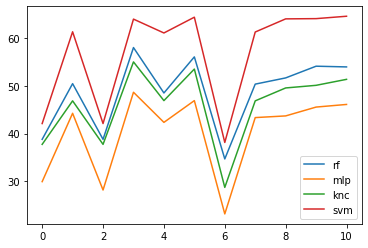

In [34]:
results = pd.DataFrame(columns=['rf', 'mlp', 'knc', 'svm'])

results['rf'] = [38.8,50.45,38.8,58.0,48.5,56.05,34.7,50.35,51.65]
results['mlp'] = [29.95,44.25,28.2,48.65,42.35,46.9,23.2,43.35,43.7]
results['knc'] = [37.75,46.85,37.75,55.0,46.9,53.5,28.75,46.85,49.55]
results['svm'] = [42.1,61.3,42.1,63.95,61.05,64.35,38.15,61.25,64]

results.loc[9] = [54.1, 45.55, 50.1, 64.05]
results.loc[10] = [53.95, 46.1, 51.35, 64.55]

display(results)
results.plot()

In [33]:
features3w02 = pd.read_csv("features3w02.csv", index_col=0)

use_RF(features3w02)
use_MLP(features3w02)
use_KNC(features3w02)
use_SVM(features3w02)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Average final accuracy estimated: 53.95%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


Average final accuracy estimated: 46.1%
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Average final accuracy estimated: 51.35%
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Average final accuracy estimated: 64.55%


In [ ]:
classifiers_performances

In [ ]:
for i in classifiers_performances.values():print(i)

In [ ]:
def flatten_dict(d):
    def items():
        for key, value in d.items():
            if isinstance(value, dict):
                for subkey, subvalue in flatten_dict(value).items():
                    yield key + "." + subkey, subvalue
            else:
                yield key, value

    return dict(items())
flatten(classifiers_performances)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_ylim(0,1)

for method in classifiers_performances.values():
    sns.boxplot(y=method['features'])


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for label in classifiers_performances_df['index']:
    sns.boxplot(x=label, y=classifiers_performances_df[classifiers_performances_df['index']==label])


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.boxplot(x=1, y=classifiers_performances['random_forest']['more_features'], ax=ax)
sns.boxplot(x=2, y=classifiers_performances['multi_layer_perceptron']['more_features'], ax=ax)
sns.boxplot(y=classifiers_performances['k_neighbors_classifier']['more_features'], ax=ax)
sns.boxplot(y=classifiers_performances['support_vector_machine']['more_features'], ax=ax)

### Neural Network

In [ ]:
def Compute_Prediction(clip, model):
    """Given a trained model over the clips dataset, this function is designed to plot a visual su"""

In [ ]:
svm_cc.best_model